In [1]:
import pandas as pd
from servier.utils import describe_df
import numpy as np
PATH = '/Users/jeanbizot/Documents/projets/PERSO/servier/servier/data/'

In [2]:
file_path = PATH + 'dataset_single.csv'
file_path_multi = PATH + 'dataset_multi.csv'

In [3]:
df = pd.read_csv(file_path)
df2 = pd.read_csv(file_path_multi)

In [4]:
df.head()

,P1,mol_id,smiles
0,1,CID2999678,Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C
1,0,CID2999679,Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1
2,1,CID2999672,COc1cc2c(cc1NC(=O)CN1C(=O)NC3(CCc4ccccc43)C1=O...
3,0,CID5390002,O=C1/C(=C/NC2CCS(=O)(=O)C2)c2ccccc2C(=O)N1c1cc...
4,1,CID2999670,NC(=O)NC(Cc1ccccc1)C(=O)O


# Rdkit exploration

In [5]:
from rdkit.Chem import rdMolDescriptors, MolFromSmiles, rdmolfiles, rdmolops, DataStructs

In [6]:
smile = "Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C"

In [7]:
mol = MolFromSmiles(smile)
new_order = rdmolfiles.CanonicalRankAtoms(mol)

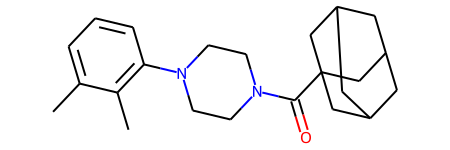

In [8]:
mol

In [9]:
list(new_order)

[0,
 17,
 4,
 3,
 5,
 18,
 24,
 11,
 9,
 23,
 16,
 2,
 25,
 14,
 21,
 6,
 20,
 7,
 22,
 8,
 15,
 13,
 10,
 12,
 19,
 1]

# Preprocessing

In [10]:
def fingerprint_features(smile_string, radius=2, size=2048):
    """
    :param smile_string:
    :param radius: no default value, usually set 2 for similarity search and 3 for machine learning
    :param size: (nBits) number of bits, default is 2048. 1024 is also widely used.
    :return:
    """
    mol = MolFromSmiles(smile_string)
    new_order = rdmolfiles.CanonicalRankAtoms(mol)
    mol = rdmolops.RenumberAtoms(mol, new_order)
    return list(rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=radius,
                                                          nBits=size,
                                                          useChirality=True,
                                                          useBondTypes=True,
                                                          useFeatures=False))

def df_to_features(df, col='smiles', radius=2, size=2048, *args, **kwargs):
    l_cols = [f'Bit_{i}' for i in range(size)]
    l_smiles = df[col].values
    vect_list = []
    for smile in l_smiles:
        fingerprint_vect = fingerprint_features(smile, radius=radius, size=size)
        vect_list.append(fingerprint_vect)
    df_morgan = pd.DataFrame(vect_list, columns=l_cols)
    df_final = pd.concat([df, df_morgan.astype('int8')], axis=1)
    return df_final

In [11]:
mol = "Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C"

In [12]:
%%time
SIZE = 1024
df_final = df_to_features(df, radius=3, size=SIZE)

CPU times: user 4.94 s, sys: 81 ms, total: 5.02 s
Wall time: 5.16 s


# Training

In [13]:
#import keras as k
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization
from keras.layers.core import Dense
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from sklearn.model_selection import train_test_split

def get_class_weights(y):
    (unique, counts) = np.unique(y, return_counts=True)
    d = {}
    for k,v in zip(unique, counts):
        d[k] = round(v/len(y), 2)
    return d

In [14]:
X = df_final.filter(regex='Bit').values
y = df_final.P1.values
w = get_class_weights(y)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.15)

In [27]:
"""NEURAL NETWORK"""
#The neural network model
def get_model(size, verbose=False):
    model = Sequential([
        Dense(size, input_shape=(size,), activation="relu"),
        Dense(256, activation="sigmoid"),
        Dense(64, activation="sigmoid"),
        Dense(34, activation="sigmoid"),
        Dense(16, activation="sigmoid"),
        BatchNormalization(axis=1),
        Dense(2, activation="softmax")
    ])
    model.compile(optimizer=Adam(lr=0.00001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [28]:
#Compiling the model
from keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(get_model, size=SIZE, batch_size=10, epochs=100, shuffle=True, class_weight=w,
                                    verbose=1, validation_data=(X_val, y_val))

In [29]:
%%time
#Training the model
model.fit(X_train, y_train)

Epoch 1/100
425/425 [==============================] - 2s 5ms/step - loss: 0.4836 - accuracy: 0.6213 - val_loss: 0.7033 - val_accuracy: 0.1840
Epoch 2/100
425/425 [==============================] - 2s 4ms/step - loss: 0.4713 - accuracy: 0.7458 - val_loss: 0.6581 - val_accuracy: 0.7960
Epoch 3/100
345/425 [=======================>......] - ETA: 0s - loss: 0.4603 - accuracy: 0.7777

KeyboardInterrupt: 

# Prediction

In [200]:
#Predictions with test dataset
y_pred = model.predict_classes(X_val, batch_size=1, verbose=1)

750/750 [==============================] - 1s 761us/step


# Evaluation

In [201]:
import copy
import matplotlib.pyplot as plt

def plot_confusion_wiki(confmat):
    fig, ax = plt.subplots(figsize=(5, 5))
    confmat_wiki = copy.copy(confmat.T)
    confmat_wiki[0][0] = confmat[1][1]
    confmat_wiki[1][1] = confmat[0][0]
    ax.matshow(confmat_wiki, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat_wiki.shape[0]):
        for j in range(confmat_wiki.shape[1]):
            ax.text(x=j, y=i, s=confmat_wiki[i, j], va='center', ha='center')
    ax.set_xticklabels([0, 1])
    ax.set_yticklabels([0, 1])
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.tight_layout()

In [202]:
from servier.utils import perf_eval_classif
perf_eval = perf_eval_classif(y_val, y_pred, verbose=False)

/Users/jeanbizot/miniconda3/envs/servier/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]
/Users/jeanbizot/miniconda3/envs/servier/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


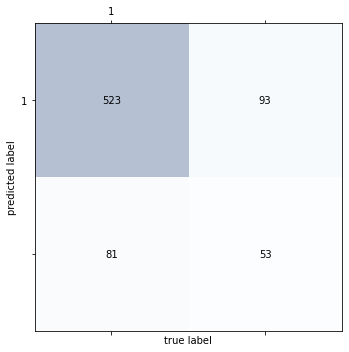

In [203]:
plot_confusion_wiki(perf_eval['confusion_matrix'])

In [171]:
perf_eval

{'f1': 0.8050632911392406,
 'ROC': 0.5438917425857724,
 'precision': 0.8383128295254832,
 'recall': 0.7743506493506493,
 'confusion_matrix': array([[ 42,  92],
        [139, 477]])}